# Session 3: Hands-On Excercises - using netUnicorn in practice

In this tutorial, we will implement an iterative approach to dataset collection using Trustee to analyze collected data and verify that our dataset doesn't have any obvious issues or shortcuts.

We will implement one of tasks for our pipeline, combine tasks into a pipeline, create an experiment, and deploy it. After we will collect the data, we will explore it using XAI tools if any shortcuts or problems are presented, and will fix them and recollect the data to improve our dataset.

In [ ]:
# Required imports

import os
import time
import pandas as pd

# netunicorn.client is responsible for your connection to the netunicorn instance
from netunicorn.client.remote import RemoteClient, RemoteClientException

# netunicorn.base contains all "building blocks" to create Tasks, Pipelines, Experiments, etc. 
from netunicorn.base import Experiment, ExperimentStatus, Pipeline, Task

## Problem definition

We will explore the problem of traffic classification between two popular video platforms - YouTube and Vimeo.

Both of these platforms allow users to upload and watch videos. We will select the same video clip on both platforms, and record the network traffic while watching it. We will extract network flows, corresponding to each video service, and try to train a machine learning classifier for them.

### Tasks implementation: ping

At first, let's meet Tasks - basic building blocks of netUnicorn API.

Tasks allow users to modularly express their intents for experiments. For example, "run the speedtest" is a Task. Tasks could be simple (start tcpdump) or very comples (watch YouTube for X seconds), users define what level of modularity the Task should implement.

Tasks would be later combined into Pipelines (for example, start tcpdump -> watch YouTube -> stop tcpdump).

Tasks consist of three parts:
- Requirements: bash commands that would be executed during compilation of a Docker image for this task. Most often used to install required programs or dependencies.
- `__init__` method: client-side initialization of the task. Allows users to pass some information to be used later (for example, URL of YouTube video to watch)
- `run` method: executor-side code that would be executed on a corresponding node. Implements actual task intent and can use information provided on the initialization step.

You can find an extensive tutorial on Tasks in [github/netunicorn/netunicorn/examples/tasks_and_dispatchers](https://github.com/netunicorn/netunicorn/blob/main/examples/tasks_and_dispatchers.ipynb)

Let's implement a simple ping task that would verify connectivity to both YouTube and Vimeo before we start doing anything. The task should do nothing during initialization except base class initialization, and implement ping with 3 packets to both "youtube.com" and "vimeo.com". In the end, return None.

In [ ]:
class PingYouTubeAndVimeoTask(Task):
    """Pings YouTube and Vimeo and returns None if success"""

    # we need to ensure that inetutils-ping package is installed in our Debian-based image
    requirements = ["apt install -y inetutils-ping"]

    def __init__(self, *args, **kwargs):
        # nothing interesting here
        super().__init__(*args, **kwargs)

    def run(self):
        # implement actual ping logic here
        # use subprocess.run to run ping to youtube.com with parameter "-c 3"
        # do the same for vimeo.com
        
        # <IMPLEMENTATION STARTS HERE>
        
        # <IMPLEMENTATION ENDS HERE>

        return None

In [ ]:
PingYouTubeAndVimeoTask().run()

Now we have a simple Task that we can use in our pipeline!

## Pipeline and Experiment creation

Great! Now let's combine our pipeline.  

Pipeline should:
 - Ping YouTube and Vimeo
 - Start tcpdump capture
 - Watch YouTube several times
 - Stop tcpdump capture
 - Start tcpdump capture again
 - Watch Vimeo several times
 - Stop tcpdump capture and save all files for local analysis
 
For all tasks, except Ping task that you implemented, we will use predefined implementations. 

Repository [netunicorn/netunicorn-library](https://github.com/netunicorn/netunicorn-library) provides implementations of different tasks and pipelines that you can use. This repository is also considered to be "contribution" repository, so anyone can create a Pull Request with their implementations of tasks or pipelines and it would be included into official netunicorn-library releases.

Currently, let's import tcpdump starting and stopping tasks, and also YouTube and Vimeo watchers.

In [ ]:
# Tasks to start tcpdump and stop named tcpdump task
from netunicorn.library.tasks.capture.tcpdump import StartCaptureLinuxImplementation, StopNamedCaptureLinuxImplementation

# Tasks for watching the corresponding video platform
from netunicorn.library.tasks.video_watchers.youtube_watcher import WatchYouTubeVideoLinuxImplementation
from netunicorn.library.tasks.video_watchers.vimeo_watcher import WatchVimeoVideoLinuxImplementation

Now, when we imported all the tasks we need, we can create a Pipeline.

Pipeline is a main block of the data collection. It's an ordered collection of tasks, separated to _stages_. Each _stage_ contains one or more tasks, and all tasks on the stage would start in parallel, and the stage would finish when all tasks of the stage would finish. Afterward, the next stage will start.

Pipeline would be deployed to working nodes (servers, PCs, VMs, anything that can run code) to be executed. After the execution, results of the pipeline would be returned to a user.

Let's create the pipeline we described above.

In [ ]:
# creating the pipeline and removing early stopping so if any task fails pipeline would go on working
pipeline = Pipeline()
pipeline.early_stopping = False

# ping youtube and vimeo
pipeline.then(PingYouTubeAndVimeoTask())

# starting tcpdump for youtube, notice the task name
pipeline.then(StartCaptureLinuxImplementation(filepath="/tmp/capture_youtube.pcap", name="capture_youtube"))

# watching youtube several times
# notice that stages have two tasks in parallel
for _ in range(4):
    pipeline.then([
        WatchYouTubeVideoLinuxImplementation("https://www.youtube.com/watch?v=dQw4w9WgXcQ", 20),
        WatchYouTubeVideoLinuxImplementation("https://www.youtube.com/watch?v=dQw4w9WgXcQ", 20),
    ])

# stopping tcpdump for youtube
# notice that Stop task have another task name as argument - all Tasks have access to results of previous tasks
pipeline.then(StopNamedCaptureLinuxImplementation(capture_task_name="capture_youtube"))

# starting tcpdump for vimeo
pipeline.then(StartCaptureLinuxImplementation(filepath="/tmp/capture_vimeo.pcap", name="capture_vimeo"))

# watching vimeo
for _ in range(3):
    pipeline.then([
        WatchVimeoVideoLinuxImplementation("https://vimeo.com/375468729", 15),
        WatchVimeoVideoLinuxImplementation("https://vimeo.com/375468729", 15),
    ])

# stopping tcpdump for vimeo
pipeline.then(StopNamedCaptureLinuxImplementation(capture_task_name="capture_vimeo"))

# let's print the resulting pipeline
for element in pipeline.tasks:
    print(element)

Now we implemented the pipeline. As you see, up to this moment we didn't need any information about where exactly this pipeline would be executed, because the code is (more or less) independent of it.

As pipelines don't have node-specific information, you can safely serialize them and share if needed.

Now, it's time to learn about our existing infrastructure. Overall infrastructure of netUnicorn looks like this:

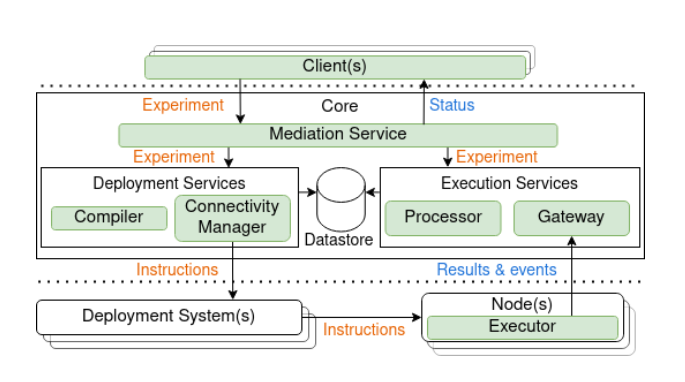

Clients (those who use netunicorn infrastructure and express tasks, pipelines, and experiments) communicate to the netUnicorn director services instance that's located close to real-world infrastructures to use. In this tutorial, we have a single AWS VM infrastructure that we will use for data collection. Director services of netUnicorn are also located on the same machine for simplicity.

To connect to any netUnicorn instance, you need to know endpoint url and a valid login-password combination. As we have instance of netunicorn deployed locally (on port 26611), let's connect there with the `test` user (with password `test`).

In [ ]:
# we have a netunicorn instance deployed locally, so let's use it
NETUNICORN_ENDPOINT = 'http://localhost:26611'
NETUNICORN_LOGIN = 'test'
NETUNICORN_PASSWORD = 'test'

# create a client and check that connection and instance are ok
client = RemoteClient(endpoint=NETUNICORN_ENDPOINT, login=NETUNICORN_LOGIN, password=NETUNICORN_PASSWORD)
client.healthcheck()

Each netUnicorn instance have information about all nodes that are available to users for execution. For example, UCSB have physical PINOT infrastructure (Raspberry Pi nodes), and also access to MS Azure and Amazon AWS cloud services, which are too represented as nodes available for calculations.

Currently, for this tutorial, we will be using localhost as the node for all experiments, so let's take it.

In [ ]:
nodes = client.get_nodes()
# nodes.filter - see API
working_nodes = nodes.take(1)
print(working_nodes)

Now we have a Pipeline and nodes to execute this pipeline on. In our simple experiment, we want to map this pipeline to just all available nodes that we do in the next cell. In other scenarios, you can (and often will) have different pipelines to map to different nodes, for example one node being a server and several other nodes being clients.

In [ ]:
# creating the experiment - mapping our pipeline to all nodes
experiment = Experiment().map(pipeline, working_nodes)
print(experiment)

Instantiation of the Experiment and mapping a Pipeline to nodes create list of Deployments - associations of a pipeline to a particular node. You can explore each of them and modify any settings.

Each Deployment describes how to create a Docker image for this particular combination of Pipeline and Host (OS version, architecture, etc). To speed up things, let's set a predefined Docker image for all deployments in our experiment - you often can do it if you have some optimized image that you know will work and support your pipeline, so it's not needed to be compiled and distributed first.

In addition to specifying the Docker image, we will also mount local folders to save PCAPs we will collect later, and remove `cleanup` flag that regulates whether to delete the Docker image afterwards.

In [ ]:
from netunicorn.base import DockerImage
for deployment in experiment:
    deployment.environment_definition = DockerImage(image='pinot.cs.ucsb.edu/sigcommtutorial:latest')  # set the required image
    deployment.environment_definition.runtime_context.additional_arguments = ["/tmp:/tmp"]             # also mount the local folder to save files
    deployment.cleanup = False                                                                         # and do not delete image afterwards

As we will save files as /tmp/capture_youtube.pcap and /tmp/capture_vimeo.pcap, let's check that we don't have them already and delete.

In [ ]:
!rm -rf /tmp/capture*

## Experiment preparation and execution

Now we have a prepared experiment - pipeline mapped to some nodes. Let's prepare and start it.

Let's name our experiment somehow, delete previous execution if it existed, and ask netunicorn to prepare the experiment

In [ ]:
experiment_label = "session3-1"

try:
    client.delete_experiment(experiment_label)
except RemoteClientException:
    pass

client.prepare_experiment(experiment, experiment_label)
time.sleep(2)

We will track preparation by periodically asking about status of the experiment

In [ ]:
while True:
    info = client.get_experiment_status(experiment_label)
    print(info.status)
    if info.status != ExperimentStatus.PREPARING:
        break
    time.sleep(10)

Let's check that all deployments are deployed correctly

In [ ]:
for deployment in client.get_experiment_status(experiment_label).experiment:
    print(f"Prepared: {deployment.prepared}, error: {deployment.error}")

Let's ask to start the execution and wait till experiment would be finished

In [ ]:
client.start_execution(experiment_label)

while True:
    info = client.get_experiment_status(experiment_label)
    print(info.status)
    if info.status != ExperimentStatus.RUNNING:
        break
    time.sleep(10)

Here's how we can get a full information about the experiment:

In [ ]:
from returns.pipeline import is_successful

for report in info.execution_result:
    print(f"Node name: {report.node.name}")    # execution node name
    print(f"Error: {report.error}")            # if any error happened

    result, log = report.result  # report stores results of execution and corresponding log
    
    # result is a returns.result.Result object, could be Success of Failure
    print(f"Result is: {type(result)}")

    # let's unwrap the result (from the Success or Failure container to the actual result)
    data = result.unwrap() if is_successful(result) else result.failure()

    # and print all task names and corresponding execution results
    for key, value in data.items():
        print(f"{key}: {value}")

    # we also can explore logs of the executor in case there's anything there
    for line in log:
        print(line.strip())
    print()

## Data preprocessing

Now we have raw PCAPs with data and need to preprocess it to convert to some features we will work with.

For this tutorial, we selected the CICFlowMeter format, which creates flow statistics features vectors from raw PCAPs. E.g., if inside your PCAP you have three connections (5-tuple flows), it will return a CSV with five rows and columns that contain this flow description (e.g., mean IAT, total length, number of packets, etc..)

For preprocessing with CICFlowMeter, we will use the prepared docker container

In [ ]:
# create a CSV for youtube traffic
!docker run -v /tmp/capture_youtube.pcap:/tmp/capture_youtube.pcap -v /tmp:/tmp/output --rm pinot.cs.ucsb.edu/cicflowmeter:latest /tmp/capture_youtube.pcap /tmp/output

In [ ]:
# create a CSV for vimeo traffic
!docker run -v /tmp/capture_vimeo.pcap:/tmp/capture_vimeo.pcap -v /tmp:/tmp/output --rm pinot.cs.ucsb.edu/cicflowmeter:latest /tmp/capture_vimeo.pcap /tmp/output

For data analysis, we will take resulting CSVs and create a random forest classif

Now let's preprocess the data:

In [ ]:
df_youtube = pd.read_csv("/tmp/capture_youtube.pcap_Flow.csv")
df_vimeo = pd.read_csv("/tmp/capture_vimeo.pcap_Flow.csv")

print(df_youtube.columns)   # these are all columns that CICFlowMeter uses

To simplify the tutorial a bit and avoid dimensionality problems (when we have too many features for our dataset size) we will use a subset of features that represent a typical video streaming flow.

In [ ]:
features = [
    "Label",
    "Protocol",
    "Flow Duration",
    "Flow Bytes/s",
    "Flow Packets/s",
    "Flow IAT Mean",
    "Bwd IAT Mean",
    "Down/Up Ratio",
    "Active Mean",
    "Idle Mean"
]

Let's clean YouTube and Vimeo traffic. We will mark all connections with more than 30 forward or backward packets as video stream connections, and will drop extra UDP traffic not related to streaming.

In [ ]:
df_youtube['Label'] = 'other'
df_youtube.loc[(df_youtube['Total Fwd Packet'] > 30) | (df_youtube['Total Bwd packets'] > 30), 'Label'] = 'youtube'  
df_youtube = df_youtube.drop(df_youtube[(df_youtube['Protocol'] == 17) & (df_youtube['Label'] != 'youtube')].index)

In [ ]:
df_vimeo['Label'] = 'other'
df_vimeo.loc[(df_vimeo['Total Fwd Packet'] > 30) | (df_vimeo['Total Bwd packets'] > 30), 'Label'] = 'vimeo'
df_vimeo = df_vimeo.drop(df_vimeo[(df_vimeo['Protocol'] == 17) & (df_vimeo['Label'] != 'vimeo')].index)

Now we can concat these two dataframes together and leave only features that we need

In [ ]:
df = pd.concat([df_youtube, df_vimeo], ignore_index=True)
df = df[features]
df = df.dropna()  # remove rows with Nones

In [ ]:
# let's look at our dataset
df.head()

## Classifier training
Now let's train a random forest classifier based on features of our data frame

In [ ]:
# required imports
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import plot_tree

In [ ]:
# separate the data frame to features and answers
target_variable = 'Label'
train_features = list(set(df.columns) - {target_variable})
x_train = df[train_features]
y_train = df[target_variable]

In [ ]:
# and start training a classifier
clf = RandomForestClassifier()
clf.fit(x_train, y_train)

Great, we have our classifier trained! Let's explore the results:

In [ ]:
y_pred = clf.predict(x_train.values)
print(metrics.classification_report(y_train, y_pred))

Look suspicious :) Let's explain the actual model with Trustee and see the reasons of such performance

## Classifier exploration and analysis

In [ ]:
from trustee import ClassificationTrustee
import matplotlib.pyplot as plt

# create and train a trustee tree
trustee = ClassificationTrustee(expert=clf)
trustee.fit(x_train, y_train, num_samples=len(x_train) // 2, num_iter=20, train_size=0.99)

# print trustee explanation results
_, dt, _, score = trustee.explain()
print(f"Training score of pruned DT: {score}")
dt_y_pred = dt.predict(x_train)

print("Model explanation global fidelity report:")
print(metrics.classification_report(clf.predict(x_train), dt_y_pred))
print("Model explanation score report:")
print(metrics.classification_report(y_train, dt_y_pred))

# plot a tree
fig = plt.figure(figsize=(25,20))
plot_tree(dt, feature_names=x_train.columns, class_names=sorted(df['Label'].unique()), filled=True, max_depth=3)

### Discussion on analysis results

## Iteration #2 - fixing the dataset
Change the pipeline to fix the problem - prohibit usage of QUIC efficiently removing protocol difference in data

In [ ]:
#creating a pipeline again

pipeline = Pipeline()
pipeline.early_stopping = False

pipeline.then(PingYouTubeAndVimeoTask())

pipeline.then(StartCaptureLinuxImplementation(filepath="/tmp/capture_youtube.pcap", name="capture_youtube"))
for _ in range(2):
    pipeline.then([
        WatchYouTubeVideoLinuxImplementation("https://www.youtube.com/watch?v=dQw4w9WgXcQ", 15, webdriver_arguments=["disable-quic"]),    # notice "disable-quic"
        WatchYouTubeVideoLinuxImplementation("https://www.youtube.com/watch?v=dQw4w9WgXcQ", 15, webdriver_arguments=["disable-quic"]),
    ])
pipeline.then(StopNamedCaptureLinuxImplementation(capture_task_name="capture_youtube"))

pipeline.then(StartCaptureLinuxImplementation(filepath="/tmp/capture_vimeo.pcap", name="capture_vimeo"))
for _ in range(2):
    pipeline.then([
        WatchVimeoVideoLinuxImplementation("https://vimeo.com/375468729", 15),
        WatchVimeoVideoLinuxImplementation("https://vimeo.com/375468729", 15),
    ])
pipeline.then(StopNamedCaptureLinuxImplementation(capture_task_name="capture_vimeo"))

for element in pipeline.tasks:
    print(element)

Again let's implement the experiment, deploy it, and run till completion.

In [ ]:
experiment = Experiment().map(pipeline, working_nodes)

for deployment in experiment:
    deployment.environment_definition = DockerImage(image='pinot.cs.ucsb.edu/sigcommtutorial:latest')
    deployment.environment_definition.runtime_context.additional_arguments = ["/tmp:/tmp"]
    deployment.cleanup = False

!rm -rf /tmp/capture*

experiment_label = "session3-2"

try:
    client.delete_experiment(experiment_label)
except RemoteClientException:
    pass

client.prepare_experiment(experiment, experiment_label)
time.sleep(2)

while True:
    info = client.get_experiment_status(experiment_label)
    print(info.status)
    if info.status != ExperimentStatus.PREPARING:
        break
    time.sleep(10)

for deployment in client.get_experiment_status(experiment_label).experiment:
    print(f"Prepared: {deployment.prepared}, error: {deployment.error}")

client.start_execution(experiment_label)

while True:
    info = client.get_experiment_status(experiment_label)
    print(info.status)
    if info.status != ExperimentStatus.RUNNING:
        break
    time.sleep(10)


for report in info.execution_result:
    print(f"Node name: {report.node.name}")
    print(f"Error: {report.error}")

    result, log = report.result  # report stores results of execution and corresponding log
    
    # result is a returns.result.Result object, could be Success of Failure
    print(f"Result is: {type(result)}")
    data = result.unwrap() if is_successful(result) else result.failure()
    for key, value in data.items():
        print(f"{key}: {value}")

    # we also can explore logs
    for line in log:
        print(line.strip())
    print()

Again using CICFlowmeter to generate data...

In [ ]:
!docker run -v /tmp/capture_youtube.pcap:/tmp/capture_youtube.pcap -v /tmp:/tmp/output --rm pinot.cs.ucsb.edu/cicflowmeter:latest /tmp/capture_youtube.pcap /tmp/output
!docker run -v /tmp/capture_vimeo.pcap:/tmp/capture_vimeo.pcap -v /tmp:/tmp/output --rm pinot.cs.ucsb.edu/cicflowmeter:latest /tmp/capture_vimeo.pcap /tmp/output

Again absolutely the same procedure for data preparation and cleaning

In [ ]:
df_youtube = pd.read_csv("/tmp/capture_youtube.pcap_Flow.csv")
df_vimeo = pd.read_csv("/tmp/capture_vimeo.pcap_Flow.csv")

df_youtube['Label'] = 'other'
df_youtube.loc[(df_youtube['Total Fwd Packet'] > 30) | (df_youtube['Total Bwd packets'] > 30), 'Label'] = 'youtube'
df_youtube = df_youtube.drop(df_youtube[(df_youtube['Protocol'] == 17) & (df_youtube['Label'] != 'youtube')].index)

df_vimeo['Label'] = 'other'
df_vimeo.loc[(df_vimeo['Total Fwd Packet'] > 30) | (df_vimeo['Total Bwd packets'] > 30), 'Label'] = 'vimeo'
df_vimeo = df_vimeo.drop(df_vimeo[(df_vimeo['Protocol'] == 17) & (df_vimeo['Label'] != 'vimeo')].index)

df = pd.concat([df_youtube, df_vimeo], ignore_index=True)
df = df[features]
df = df.dropna()

target_variable = 'Label'
features = list(set(df.columns) - {target_variable})
x_train = df[features]
y_train = df[target_variable]

And also training a classifier, explaining it with Trustee, and visualizing the results

In [ ]:
clf = RandomForestClassifier()
clf.fit(x_train, y_train)

y_pred = clf.predict(x_train.values)
print(metrics.classification_report(y_train, y_pred))

trustee = ClassificationTrustee(expert=clf)
trustee.fit(x_train, y_train, num_samples=len(x_train) // 2, num_iter=20, train_size=0.99)

_, dt, _, score = trustee.explain()
print(f"Training score of pruned DT: {score}")
dt_y_pred = dt.predict(x_train)

print("Model explanation global fidelity report:")
print(metrics.classification_report(clf.predict(x_train), dt_y_pred))
print("Model explanation score report:")
print(metrics.classification_report(y_train, dt_y_pred))

fig = plt.figure(figsize=(25,20))
plot_tree(dt, feature_names=x_train.columns, class_names=sorted(df['Label'].unique()), filled=True, max_depth=3)

## Iteration #2 - results discussion

## Instructor-only part: PINOT demo

In [16]:
# # Instructor-only cell: deploying the same experiment to PINOT infrastructure
# import os
# if '.env' in os.listdir():
#     from dotenv import load_dotenv
#     load_dotenv(".env")

# client = RemoteClient(endpoint=os.environ.get('NETUNICORN_ENDPOINT'), login=os.environ.get('NETUNICORN_LOGIN'), password=os.environ.get('NETUNICORN_PASSWORD'))
# client.healthcheck()

# nodes = client.get_nodes()
# print(nodes)
# working_nodes = nodes.filter(lambda node: node.name.startswith("raspi")).take(15)
# experiment = Experiment().map(pipeline, working_nodes)

In [14]:
# # Instructor-only cell: deploying the same experiment to PINOT infrastructure
# experiment_label = "session3-pinot-1"
# client.prepare_experiment(experiment, experiment_label)

In [15]:
# # Instructor-only cell: deploying the same experiment to PINOT infrastructure
# client.get_experiment_status(experiment_label)

## Results from PINOT infrastructure

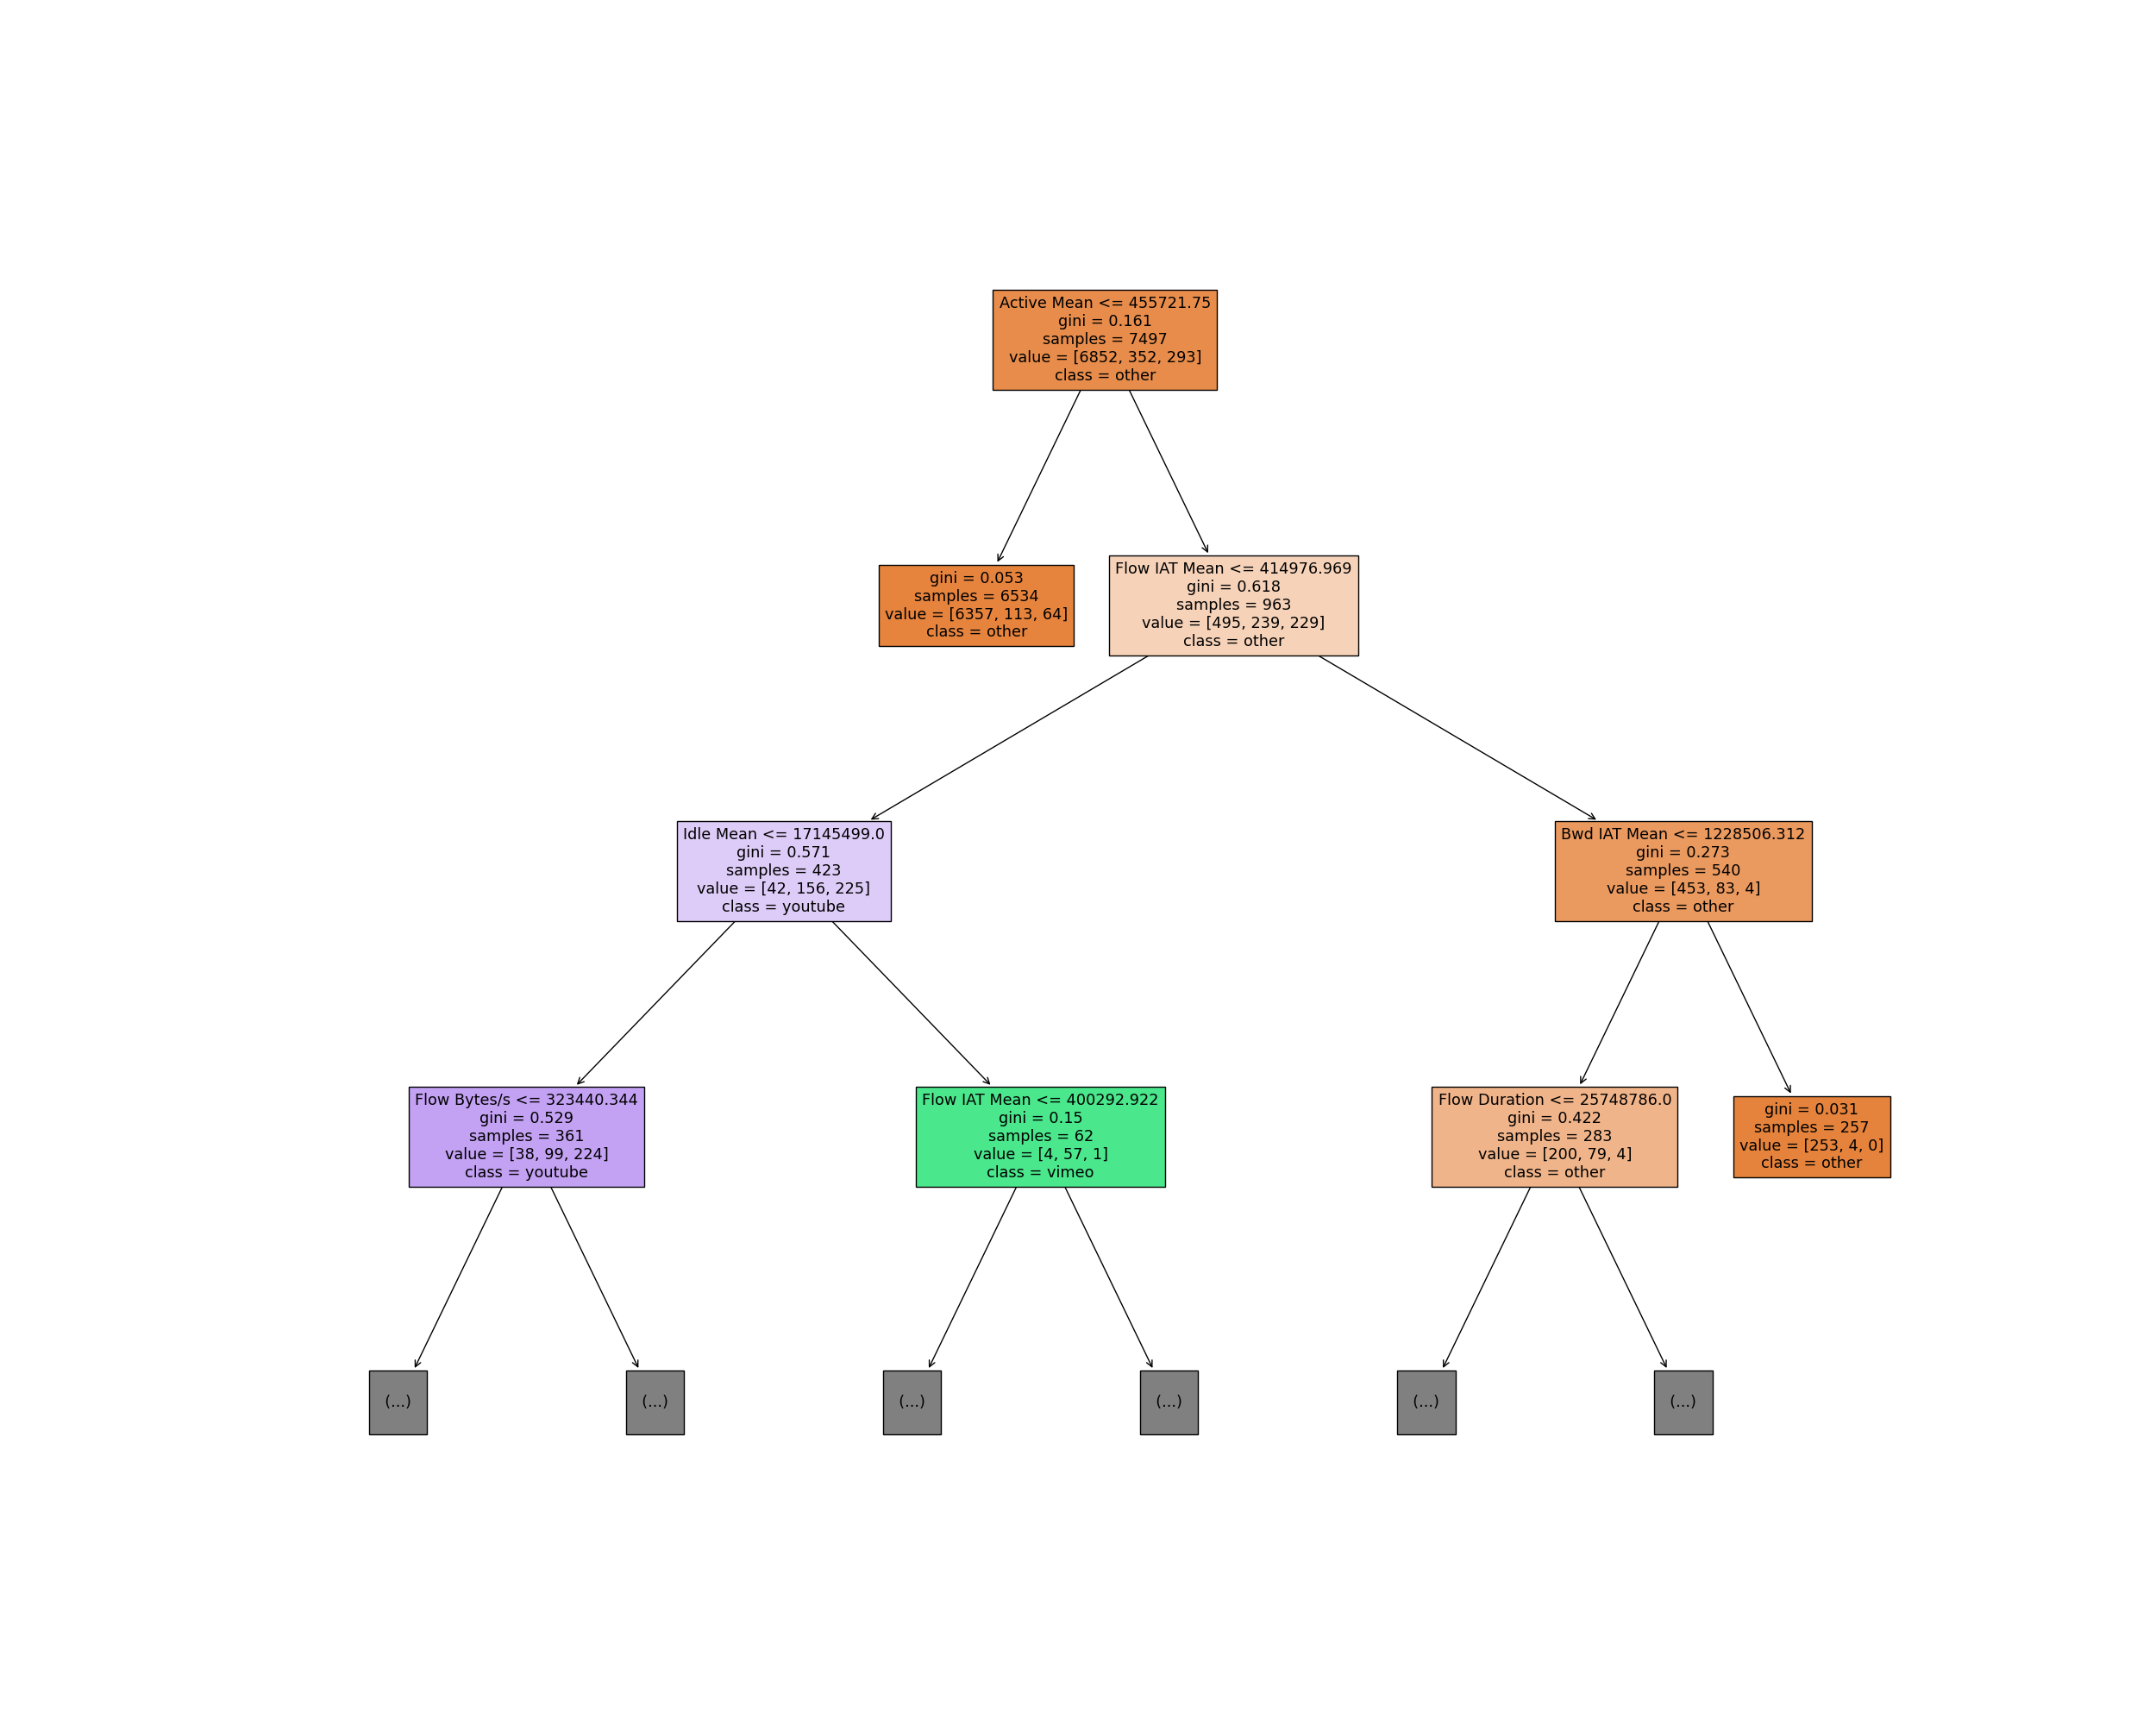

## Iteration #3: improving the dataset

In [ ]:
from netunicorn.library.tasks.video_watchers.twitch_watcher import WatchTwitchStreamLinuxImplementation

In [3]:
# In this cell, you should create a new pipeline on base of the previous one with the next modifications:
# 1. Increase video diversity in the current pipeline
# 2. Explore the Twitch task and add it to the pipeline as well
# 3. Add tcpdump capture for Twitch traffic as well

pipeline = ...

In [9]:
# In this cell you need to create a new experiment version, deploy it, verify that it was deployed succesfully, execute, and explore results of the execution
...

In [10]:
# In this cell, preprocess the resulting PCAPs with CICFlowMeter into corresponding CSV files. Don't forget about Twitch
...

In [11]:
# In this cell, you should preprocess YouTube, Vimeo, and Twitch data and label it.
# Use the same flow identification strategy for Twitch, as for other services.
...

Ellipsis

In [12]:
# In this cell, train a classifier on your new data, explain it with Trustee, 
# and try to think of why this particular rule was used to separate Twitch streams. 
# Is it a possible shortcut or a valid feature?
...

Ellipsis